# Prepare run

## Import libraries and functions

Using a Pytorch-based CREsted environment with tangermeme installed

In [1]:
import os
import torch
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
import pickle
import crested
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from crested.tl.data import AnnDataModule
from scipy.stats import pearsonr, spearmanr
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4")
deepccl_dir = Path(f'deepccl/results/modisco')
deepccl_path = data_dir.joinpath(deepccl_dir)

deepglioma_dir = Path(f'deepglioma/results/modisco')
deepglioma_path = data_dir.joinpath(deepglioma_dir)

# Motif comparison between DeepCCL and DeepGlioma (Figure 4h/i)

### Match patterns across cell lines and topics

In [4]:
top_k = 2000
topics_of_interest = ['Topic14', 'Topic18', 'Topic19', 'Topic8', 'Topic20', 'Topic21', 'Topic5', 'Topic25']
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']

matched_files = {}
matched_files_biopsy = crested.tl.modisco.match_h5_files_to_classes(
    classes=topics_of_interest,
    contribution_dir=f"{str(deepglioma_path)}/atacpred_prop_tfmodisco_results_{top_k}",
)
for key, value in matched_files_biopsy.items():
    matched_files[f'{key}_biopsy_model'] = value

matched_files_cl = crested.tl.modisco.match_h5_files_to_classes(
    classes=classes_of_interest,
    contribution_dir=f"{str(deepccl_path)}/finetuned_model"
)
for key, value in matched_files_cl.items():
    matched_files[f'{key}_cl_model'] = value

In [5]:
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=3.5,
    trim_ic_threshold=0.1,
    discard_ic_threshold=0.2,
    verbose=True,
)

pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)

Reading file /staging/leuven/stg_00002/lcb/vkonst/Projects/CREsted/data/deepglioma/results/modisco/atacpred_prop_tfmodisco_results_2000/Topic14_modisco_results.h5
Match between Topic14_biopsy_model_pos_patterns_4 and Topic14_biopsy_model_pos_patterns_3 with similarity score 6.73
Match between Topic14_biopsy_model_pos_patterns_5 and Topic14_biopsy_model_pos_patterns_3 with similarity score 3.82
Match between Topic14_biopsy_model_pos_patterns_6 and Topic14_biopsy_model_pos_patterns_5 with similarity score 5.57
Match between Topic14_biopsy_model_pos_patterns_8 and Topic14_biopsy_model_pos_patterns_7 with similarity score 5.15
Match between Topic14_biopsy_model_pos_patterns_10 and Topic14_biopsy_model_pos_patterns_9 with similarity score 4.36
Reading file /staging/leuven/stg_00002/lcb/vkonst/Projects/CREsted/data/deepglioma/results/modisco/atacpred_prop_tfmodisco_results_2000/Topic18_modisco_results.h5
Match between Topic18_biopsy_model_pos_patterns_0 and Topic14_biopsy_model_pos_patterns_

In [6]:
with open(f"{deepccl_path}/deepglioma_comparison/all_patterns.pkl", 'wb') as f:
    pickle.dump(all_patterns, f)

np.save(f"{deepccl_path}/deepglioma_comparison/pattern_matrix.npy", pattern_matrix)

### Plot clustermap

To save time, we can also load the pattern matrix and pattern dictionary directly.

In [10]:
with open(f"{deepccl_path}/deepglioma_comparison/all_patterns.pkl", 'rb') as f:
    all_patterns = pickle.load(f)

pattern_matrix = np.load(f"{deepccl_path}/deepglioma_comparison/pattern_matrix.npy")

In [11]:
# Create a copy and zero out noisy columns
pattern_matrix_copy = pattern_matrix.copy()
noisy_motifs = [30, 31, 34, 40, 42, 43, 44, 67, 76, 81, 82, 83, 84]
pattern_matrix_copy[:, noisy_motifs] = 0

all_patterns['7']['pattern'] = all_patterns['7']['instances']['Topic18_biopsy_model_pos_patterns_4']
all_patterns['9']['pattern'] = all_patterns['9']['instances']['Topic5_biopsy_model_neg_patterns_0']
all_patterns['41']['pattern'] = all_patterns['41']['instances']['a172_cl_model_pos_patterns_7']
all_patterns['69']['pattern'] = all_patterns['69']['instances']['m059j_cl_model_pos_patterns_9']

## Figure 4h

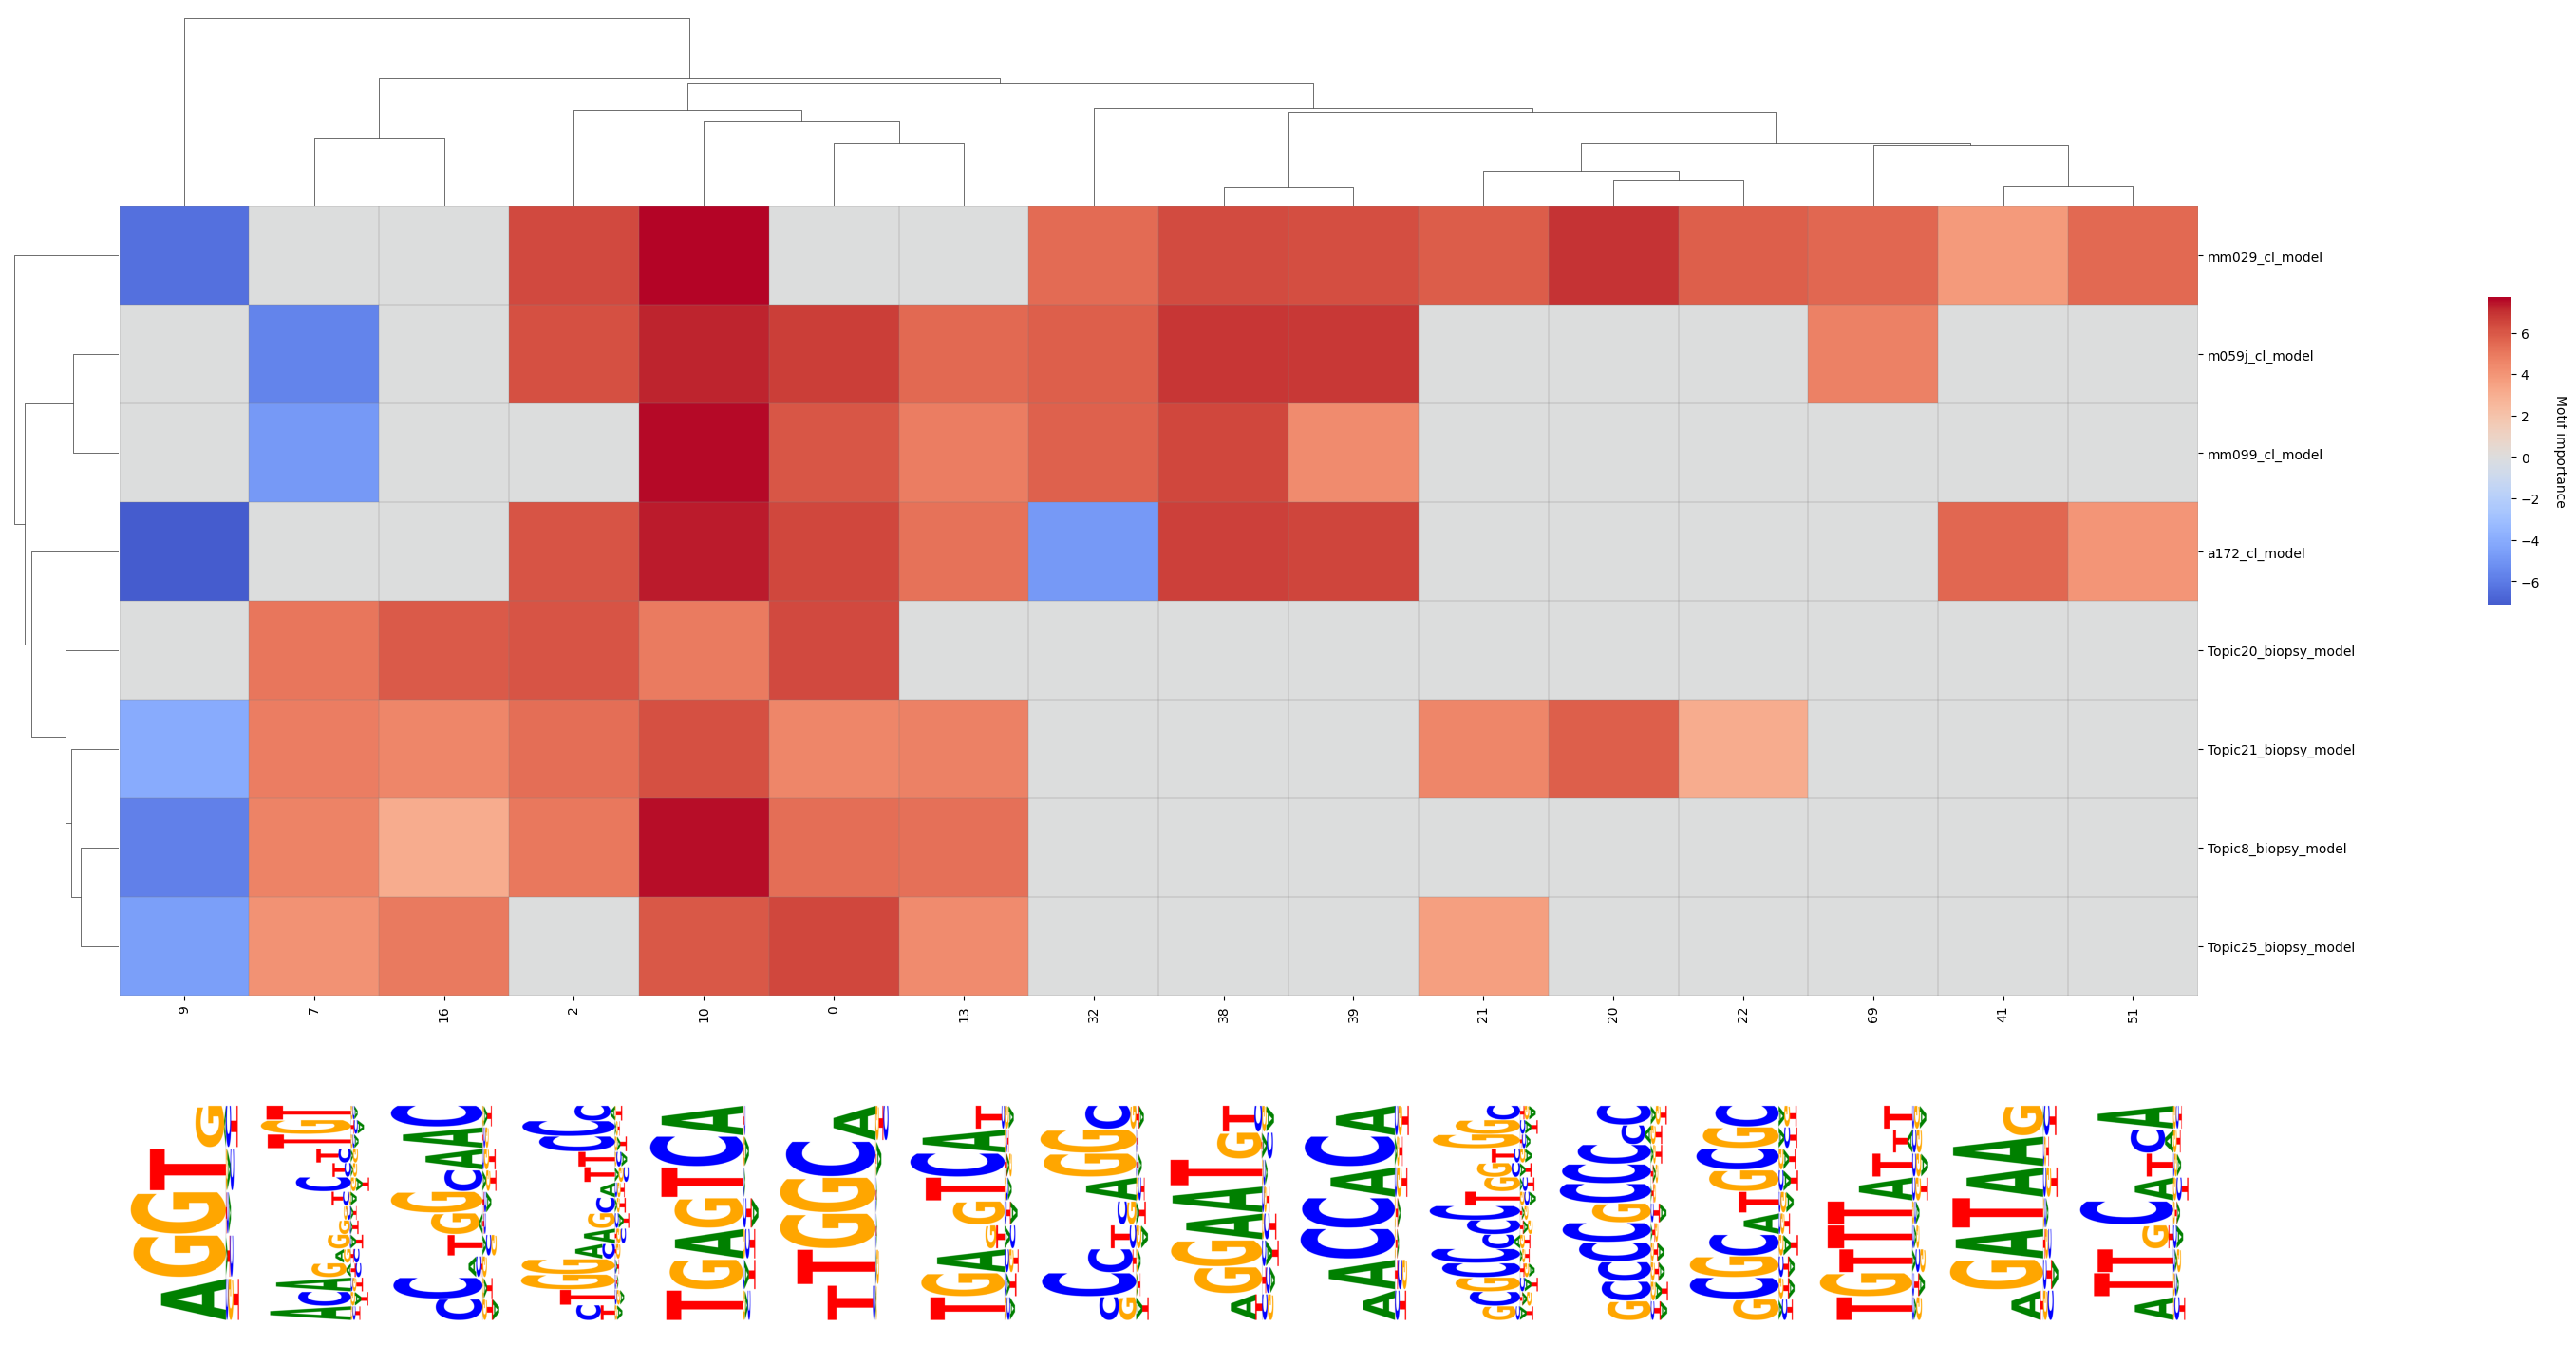

In [12]:
selected_classes = [
    'Topic20_biopsy_model',
    'Topic25_biopsy_model',
    'Topic21_biopsy_model',
    'Topic8_biopsy_model',
    'a172_cl_model',
    'm059j_cl_model',
    'mm029_cl_model',
    'mm099_cl_model',
]

crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix_copy,
    classes=list(matched_files.keys()),
    subset=selected_classes,
    pattern_dict=all_patterns,
    figsize=(25, 8),
    grid=True,
    importance_threshold=5.0,
);

## Figure 4i

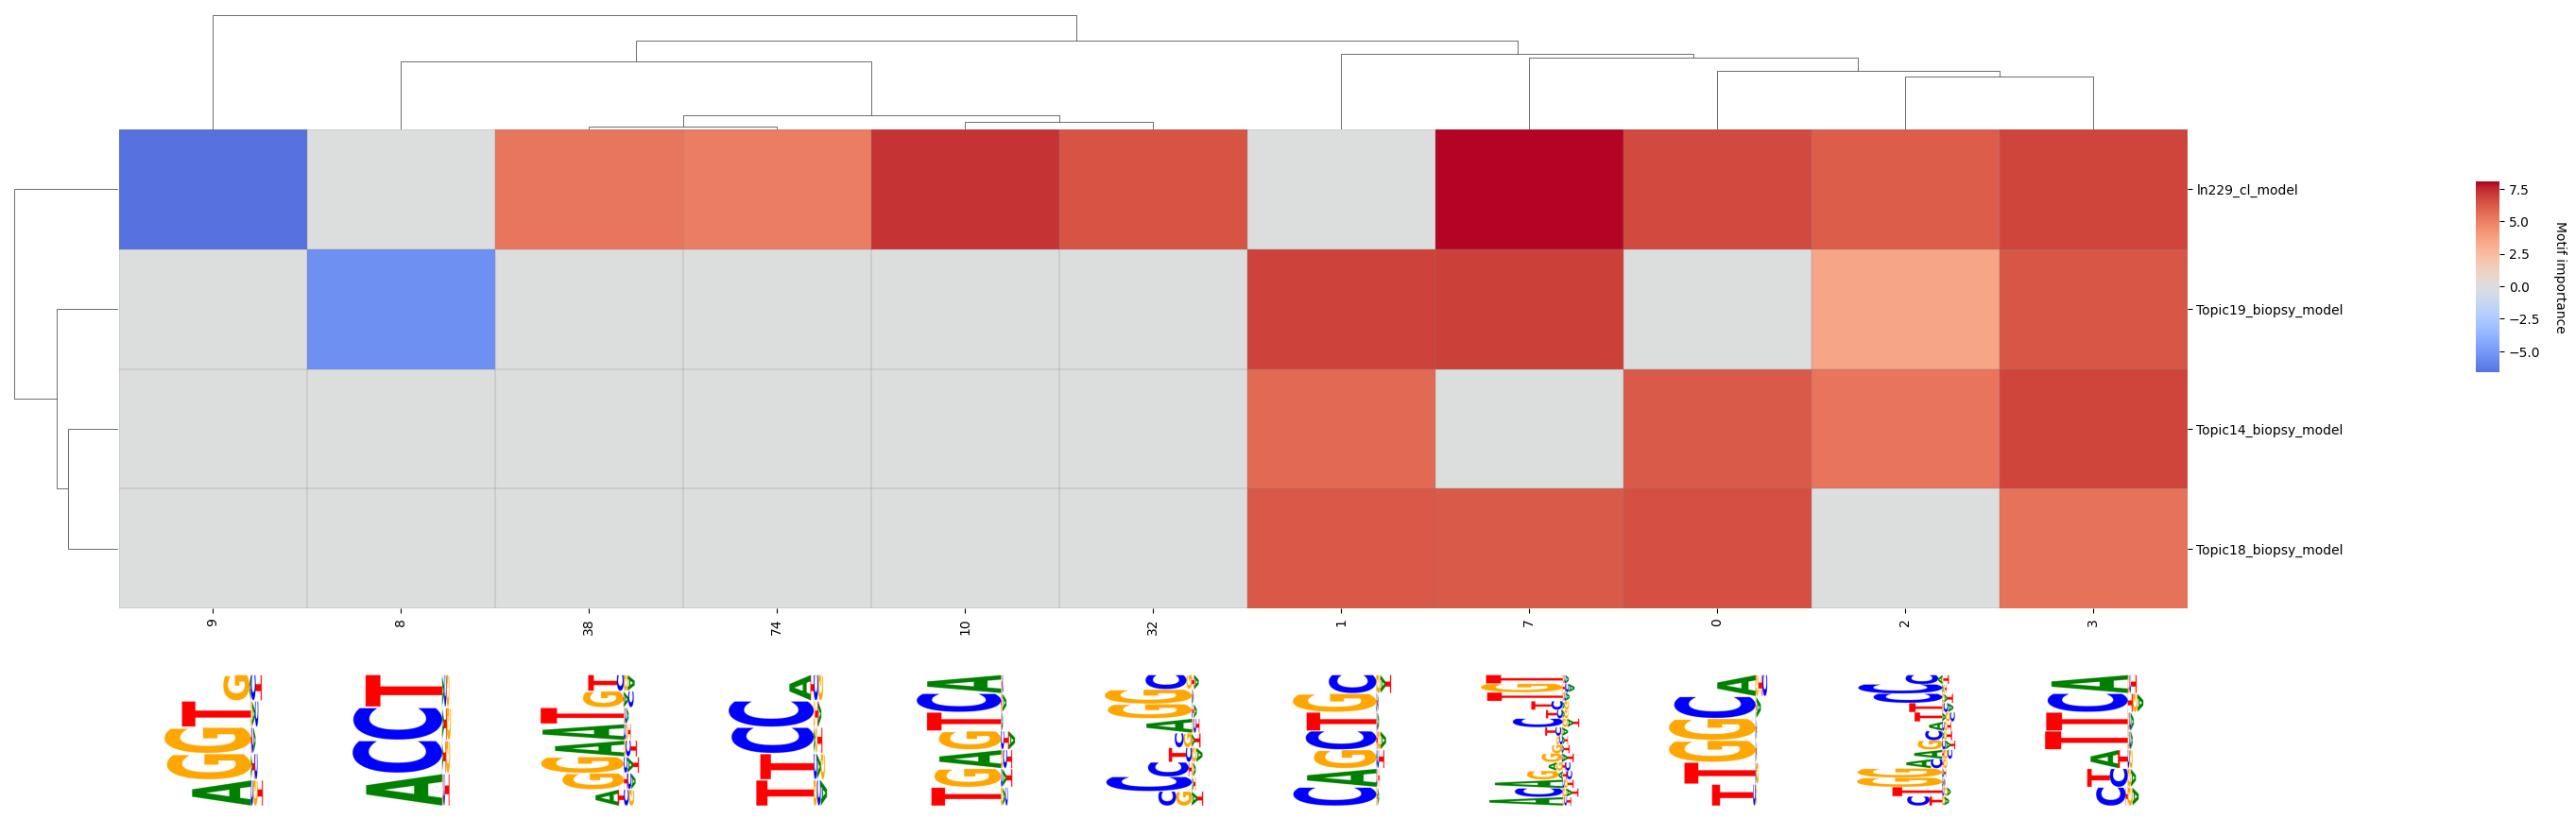

In [13]:
selected_classes = [
    'Topic19_biopsy_model',
    'Topic18_biopsy_model',
    'Topic14_biopsy_model',
    'ln229_cl_model',
]

crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix_copy,
    classes=list(matched_files.keys()),
    subset=selected_classes,
    pattern_dict=all_patterns,
    figsize=(25, 5),
    grid=True,
    importance_threshold=5.0,
);